In [ ]:
1+1

2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

class CaroEnv:
    def __init__(self, board_size=10):
        self.board_size = board_size
        self.reset()

    def reset(self):
        self.board = np.zeros((self.board_size, self.board_size), dtype=int)
        self.done = False
        self.current_player = 1
        self.last_move = None
        self.winning_coords = []

        # ‚úÖ Agent m·∫∑c ƒë·ªãnh ƒë√°nh tr∆∞·ªõc t·∫°i √¥ c·ªë ƒë·ªãnh (v√≠ d·ª•: gi·ªØa b√†n)
        x0, y0 = self.board_size // 2, self.board_size // 2
        self.board[x0, y0] = self.current_player
        self.last_move = (x0, y0)
        self.current_player *= -1  # ƒê·ªïi l∆∞·ª£t cho ƒë·ªëi th·ªß

        return self.board.copy()

    def step(self, action):
        x, y = action
        if self.board[x, y] != 0 or self.done:
            return self.board.copy(), 0, False, {"invalid": True}

        self.board[x, y] = self.current_player
        self.last_move = (x, y)

        win, coords = self.check_win(x, y)
        if win:
            self.done = True
            self.winning_coords = coords
            reward = 3 if self.current_player == 1 else -1
            reward = max(min(reward, 4), -1)
            return self.board.copy(), reward, True, {"winner": self.current_player}

        elif np.all(self.board != 0):
            self.done = True
            return self.board.copy(), 1, True, {"winner": 0}

        else:
            reward = 0.0
            longest_chain = self.get_longest_chain(x, y)
            reward += min(0.1 * (longest_chain - 1), 0.5)

            if self.current_player == 1:
                threat_map = self.get_threat_map()
                if threat_map[x, y] >= 4:
                    reward += 0.75
                elif threat_map[x, y] == 3:
                    reward += 0.5

            reward = max(min(reward, 4), -1)
            self.current_player *= -1
            return self.board.copy(), reward, False, {}

    def get_longest_chain(self, x, y):
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]
        player = self.board[x, y]
        max_len = 0

        for dx, dy in directions:
            count = 1
            for d in [1, -1]:
                nx, ny = x + d*dx, y + d*dy
                while 0 <= nx < self.board_size and 0 <= ny < self.board_size and self.board[nx, ny] == player:
                    count += 1
                    nx += d * dx
                    ny += d * dy
            if count > max_len:
                max_len = count

        return max_len

    def get_threat_map(self):
        threat_map = np.zeros_like(self.board, dtype=float)
        opponent = -self.current_player

        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.board[i, j] == 0:
                    self.board[i, j] = opponent
                    chain_len = self.get_longest_chain(i, j)
                    threat_map[i, j] = chain_len
                    self.board[i, j] = 0

        return threat_map

    def check_win(self, x, y):
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]
        player = self.board[x, y]

        for dx, dy in directions:
            coords = [(x, y)]
            for d in [1, -1]:
                nx, ny = x + d * dx, y + d * dy
                while 0 <= nx < self.board_size and 0 <= ny < self.board_size and self.board[nx, ny] == player:
                    coords.append((nx, ny))
                    nx += d * dx
                    ny += d * dy

            if len(coords) >= 5:
                return True, coords

        return False, []

    def render(self):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(np.ones((self.board_size, self.board_size)), cmap='gray_r')

        if self.last_move:
            x, y = self.last_move
            ax.add_patch(plt.Rectangle((y - 0.5, x - 0.5), 1, 1, fill=True, color='yellow', alpha=0.3))

        for (i, j) in self.winning_coords:
            ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=True, color='lime', alpha=0.3))

        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.board[i, j] == 1:
                    ax.text(j, i, 'X', va='center', ha='center', color='blue', fontsize=12)
                elif self.board[i, j] == -1:
                    ax.text(j, i, 'O', va='center', ha='center', color='red', fontsize=12)

        ax.set_xticks(np.arange(self.board_size))
        ax.set_yticks(np.arange(self.board_size))
        ax.set_xticklabels([str(i) for i in range(self.board_size)])
        ax.set_yticklabels([str(i) for i in range(self.board_size)])

        ax.set_xticks(np.arange(-0.5, self.board_size, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.board_size, 1), minor=True)
        ax.grid(which='minor', color='black', linewidth=0.5)

        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        plt.show()

# =================== Chi·∫øn thu·∫≠t ===================

    def get_strategic_action(self, board, player):
        candidate_actions = [(i, j) for i in range(self.board_size) for j in range(self.board_size) if board[i, j] == 0]

        # 1. T·∫°o n∆∞·ªõc 5 ƒë·ªÉ th·∫Øng
        for x, y in candidate_actions:
            board[x, y] = player
            if self.check_chain(board, x, y, player) >= 5:
                board[x, y] = 0
                return (x, y)
            board[x, y] = 0

        # 2. Ch·∫∑n n∆∞·ªõc 5 c·ªßa ƒë·ªëi th·ªß
        opponent = -player
        for x, y in candidate_actions:
            board[x, y] = opponent
            if self.check_chain(board, x, y, opponent) >= 5:
                board[x, y] = 0
                return (x, y)
            board[x, y] = 0

        # 3. T·∫°o n∆∞·ªõc 4
        for x, y in candidate_actions:
            board[x, y] = player
            if self.check_chain(board, x, y, player) == 4:
                board[x, y] = 0
                return (x, y)
            board[x, y] = 0

        # 4. Ch·∫∑n n∆∞·ªõc 3 m·ªü c·ªßa ƒë·ªëi th·ªß
        block_positions = []
        for x, y in candidate_actions:
            if self.is_open_three(board, x, y, opponent):
                block_positions.append((x, y))
        if block_positions:
            return random.choice(block_positions)




    def check_chain(self, board, x, y, player):
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]
        max_len = 0

        for dx, dy in directions:
            count = 1
            for d in [1, -1]:
                nx, ny = x + dx * d, y + dy * d
                while 0 <= nx < self.board_size and 0 <= ny < self.board_size and board[nx, ny] == player:
                    count += 1
                    nx += dx * d
                    ny += dy * d
            max_len = max(max_len, count)

        return max_len


    def is_open_three(self, board, x, y, player):
        if board[x, y] != 0:
            return False

        board[x, y] = player
        open_three = False
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]

        for dx, dy in directions:
            count = 1
            blocks = 0
            for d in [1, -1]:
                nx, ny = x + dx * d, y + dy * d
                while 0 <= nx < self.board_size and 0 <= ny < self.board_size:
                    if board[nx, ny] == player:
                        count += 1
                        nx += dx * d
                        ny += dy * d
                    elif board[nx, ny] == 0:
                        break
                    else:
                        blocks += 1
                        break
            if count == 3 and blocks == 0:
                open_three = True
                break

        board[x, y] = 0
        return open_three



    def get_valid_actions(self):
        return [(i, j) for i in range(self.board_size) for j in range(self.board_size) if self.board[i, j] == 0]



In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def play_with_bot(bot_class):
    # Kh·ªüi t·∫°o m√¥i tr∆∞·ªùng v√† bot theo class truy·ªÅn v√†o
    env = CaroEnv(board_size=10)
    bot = bot_class(env)
    state = env.reset()

    # T·∫°o c√°c √¥ nh·∫≠p v√† n√∫t
    row_input = widgets.BoundedIntText(min=0, max=9, description='H√†ng:')
    col_input = widgets.BoundedIntText(min=0, max=9, description='C·ªôt:')
    play_button = widgets.Button(description="ƒê√°nh")
    reset_button = widgets.Button(description="üîÑ Ch∆°i l·∫°i", button_style='warning')
    output = widgets.Output()

    # H√†m x·ª≠ l√Ω khi b·∫•m n√∫t "ƒê√°nh"
    def on_play_click(b):
        nonlocal state
        with output:
            clear_output(wait=True)

            if env.done:
                print("üéÆ Tr√≤ ch∆°i ƒë√£ k·∫øt th√∫c. B·∫•m 'Ch∆°i l·∫°i' ƒë·ªÉ b·∫Øt ƒë·∫ßu v√°n m·ªõi.")
                display(row_input, col_input, play_button, reset_button)
                return

            x, y = row_input.value, col_input.value

            state, reward, done, info = env.step((x, y))
            if info.get("invalid", False):
                print("‚õî √î ƒë√£ ƒë√°nh r·ªìi! H√£y ch·ªçn √¥ kh√°c.")
                env.render()
                display(row_input, col_input, play_button, reset_button)
                return


            # Ng∆∞·ªùi ch∆°i ƒë√°nh
            state, reward, done, info = env.step((x, y))
            env.render()

            if done:
                if info['winner'] == 1:
                    print("üéâ B·∫°n th·∫Øng!")
                elif info['winner'] == -1:
                    print("ü§ñ Bot th·∫Øng!")
                elif info['winner'] == 0:
                    print("ü§ù H√≤a!")
                else:
                    print("‚ùå L·ªói!")
                display(row_input, col_input, play_button, reset_button)
                return

            # Bot ƒë√°nh
            bot_action = bot.select_action(state)
            state, reward, done, info = env.step(bot_action)
            print(f"ü§ñ Bot ƒë√°nh v√†o ({bot_action[0]}, {bot_action[1]})")
            env.render()

            if done:
                if info['winner'] == 1:
                    print("üéâ Bot th·∫Øng!")
                elif info['winner'] == -1:
                    print("ü§ñ Ban th·∫Øng!")
                elif info['winner'] == 0:
                    print("ü§ù H√≤a!")
                else:
                    print("‚ùå L·ªói!")

            display(row_input, col_input, play_button, reset_button)

    # H√†m x·ª≠ l√Ω khi b·∫•m n√∫t "Ch∆°i l·∫°i"
    def on_reset_click(b):
        nonlocal state, env, bot
        env = CaroEnv(env.board_size)
        bot = bot_class(env)
        center = env.board_size // 2
        state = env.reset()
        env.board[center, center] = 1
        env.current_player = -1
        env.last_move = (center, center)
        with output:
            clear_output(wait=True)
            print(f"ü§ñ Bot ƒë√°nh v√†o ({center}, {center})")
            env.render()
            display(row_input, col_input, play_button, reset_button)


    # G·∫Øn s·ª± ki·ªán
    play_button.on_click(on_play_click)
    reset_button.on_click(on_reset_click)

    # Hi·ªÉn th·ªã giao di·ªán ban ƒë·∫ßu
    with output:
        clear_output(wait=True)
        center = env.board_size // 2
        state = env.reset()
        env.board[center, center] = 1
        env.current_player = -1
        env.last_move = (center, center)
        print(f"ü§ñ Bot ƒë√°nh v√†o ({center}, {center})")
        env.render()
        display(row_input, col_input, play_button, reset_button)

    display(output)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import random
import numpy as np

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = np.concatenate(states, axis=0)
        next_states = np.concatenate(next_states, axis=0)

        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.long),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)

    def get_data(self):
        return list(self.buffer)

    def load_data(self, data):
        self.buffer = deque(data, maxlen=self.capacity)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # Skip connection
        return F.relu(out)

class CaroDQN(nn.Module):
    def __init__(self, board_size=10):
        super(CaroDQN, self).__init__()
        self.board_size = board_size

        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.res1 = ResidualBlock(64)
        self.res2 = ResidualBlock(64)

        self.flatten = nn.Flatten()
        conv_output_size = 64 * board_size * board_size
        self.fc1 = nn.Linear(conv_output_size, 512)
        self.fc2 = nn.Linear(512, board_size * board_size)

    def forward(self, x):  # x: [B, 2, H, W]
        x = F.relu(self.bn1(self.conv1(x)))  # [B, 32, H, W]
        x = F.relu(self.bn2(self.conv2(x)))  # [B, 64, H, W]

        x = self.res1(x)  # [B, 64, H, W]
        x = self.res2(x)  # [B, 64, H, W]

        x = self.flatten(x)  # [B, 64*H*W]
        x = F.relu(self.fc1(x))  # [B, 512]
        return self.fc2(x)       # [B, H*W]


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # Skip connection
        return F.relu(out)

class CaroDDQN(nn.Module):
    def __init__(self, board_size=10):
        super(CaroDDQN, self).__init__()
        self.board_size = board_size

        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.res1 = ResidualBlock(64)
        self.res2 = ResidualBlock(64)

        self.flatten = nn.Flatten()
        conv_output_size = 64 * board_size * board_size
        self.fc1 = nn.Linear(conv_output_size, 512)
        self.fc2 = nn.Linear(512, board_size * board_size)

    def forward(self, x):  # x: [B, 2, H, W]
        x = F.relu(self.bn1(self.conv1(x)))  # [B, 32, H, W]
        x = F.relu(self.bn2(self.conv2(x)))  # [B, 64, H, W]

        x = self.res1(x)  # [B, 64, H, W]
        x = self.res2(x)  # [B, 64, H, W]

        x = self.flatten(x)  # [B, 64*H*W]
        x = F.relu(self.fc1(x))  # [B, 512]
        return self.fc2(x)       # [B, H*W]


In [ ]:
# Load model DQN
modeldqn = CaroDQN(board_size=10)
modeldqn.load_state_dict(torch.load("caro_dqn_final.pth"))
modeldqn.eval()

# Load model DDQN
modelddqn = CaroDDQN(board_size=10)
modelddqn.load_state_dict(torch.load("caro_Ddqn_final.pth"))
modelddqn.eval()

# T·∫°o m·ªôt environment d√πng chung
env = CaroEnv(board_size=10)


In [ ]:
class TrainedAgent:
    def __init__(self, model, env, player=1):
        self.model = model
        self.env = env
        self.board_size = env.board_size
        self.player = player  # 1 ho·∫∑c -1

    def select_action(self, board):
        # 1. D√πng logic chi·∫øn thu·∫≠t n·∫øu c√≥

        move = self.env.get_strategic_action(board.copy(), player=self.player)
        if move is not None:
            return move

        # 2. Kh√¥ng c√≥ n∆∞·ªõc chi·∫øn thu·∫≠t ‚Üí d√πng model
        with torch.no_grad():
            agent_channel = (board == self.player).astype(np.float32)
            opponent_channel = (board == -self.player).astype(np.float32)
            x = np.stack([agent_channel, opponent_channel], axis=0)
            x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(next(self.model.parameters()).device)

            q_values = self.model(x).view(self.board_size, self.board_size)
            mask = (torch.tensor(board) == 0)
            q_values[~mask] = -float('inf')
            idx = torch.argmax(q_values).item()
            return (idx // self.board_size, idx % self.board_size)


In [ ]:
def play_match(env, agent1, agent2):
    state = env.reset()
    done = False
    turn = 0  # 0: agent1, 1: agent2

    while not done:
        if turn == 0:
            action = agent1.select_action(state)
            next_state, reward, done, info = env.step(action)
        else:
            action = agent2.select_action(state)
            next_state, reward, done, info = env.step(action)

        state = next_state
        turn = 1 - turn

        if done:
            winner = info.get('winner', None)
            if winner == agent1.player:
                return 1  # agent1 th·∫Øng
            elif winner == agent2.player:
                return -1  # agent2 th·∫Øng
            else:
                return 0  # H√≤a

    return 0


In [ ]:
import time

def play_match_verbose(env, agent1, agent2, delay=1.0):
    state = env.reset()
    done = False
    turn = 0  # 0: agent1, 1: agent2

    # G√°n t√™n cho d·ªÖ theo d√µi
    name1 = "DQN" if agent1.player == 1 else "DDQN"
    name2 = "DQN" if agent2.player == 1 else "DDQN"

    print(f"B·∫Øt ƒë·∫ßu tr·∫≠n ƒë·∫•u: {name1} (player {agent1.player}) vs {name2} (player {agent2.player})")
    env.render()
    print("-" * 30)

    while not done:
        if turn == 0:
            action = agent1.select_action(state)
            print(f"{name1} ch·ªçn n∆∞·ªõc ƒëi: {action}")
        else:
            action = agent2.select_action(state)
            print(f"{name2} ch·ªçn n∆∞·ªõc ƒëi: {action}")

        state, reward, done, info = env.step(action)

        env.render()
        print("-" * 30)
        time.sleep(delay)

        turn = 1 - turn

    # K·∫øt qu·∫£
    winner = info.get("winner", 0)
    if winner == agent1.player:
        print(f"üéâ {name1} th·∫Øng!")
    elif winner == agent2.player:
        print(f"üéâ {name2} th·∫Øng!")
    else:
        print("ü§ù H√≤a!")


DQN vs DDQN: 11 wins (DQN), 12 wins (DDQN), 27 draws in 50 matches.

Final match board:


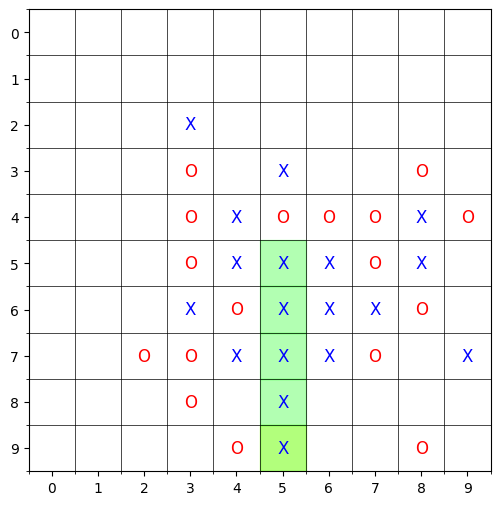

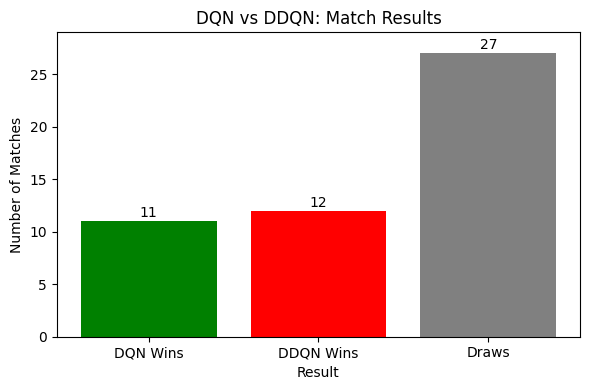

In [ ]:
import matplotlib.pyplot as plt

def main():
    env = CaroEnv(board_size=10)

    # Kh·ªüi t·∫°o agent v·ªõi player m·∫∑c ƒë·ªãnh (s·∫Ω c·∫≠p nh·∫≠t l·∫°i t·ª´ng tr·∫≠n)
    agentdqn = TrainedAgent(modeldqn, env, player=1)
    agentddqn = TrainedAgent(modelddqn, env, player=-1)

    dqn_wins = 0
    ddqn_wins = 0
    draws = 0
    matches = 50

    last_env = None

    for i in range(matches):
        current_env = CaroEnv(board_size=10)

        if i % 2 == 0:
            # DQN ƒëi tr∆∞·ªõc
            agentdqn.player = 1
            agentddqn.player = -1
            result = play_match(current_env, agentdqn, agentddqn)
        else:
            # DDQN ƒëi tr∆∞·ªõc
            agentdqn.player = -1
            agentddqn.player = 1
            result = play_match(current_env, agentddqn, agentdqn)

        if i == matches - 1:
            last_env = current_env

        # C·∫≠p nh·∫≠t k·∫øt qu·∫£ d·ª±a theo ng∆∞·ªùi th·∫Øng
        if result == 1:
            if i % 2 == 0:
                dqn_wins += 1
            else:
                ddqn_wins += 1
        elif result == -1:
            if i % 2 == 0:
                ddqn_wins += 1
            else:
                dqn_wins += 1
        else:
            draws += 1

    print(f"DQN vs DDQN: {dqn_wins} wins (DQN), {ddqn_wins} wins (DDQN), {draws} draws in {matches} matches.")

    # Hi·ªÉn th·ªã tr·∫≠n cu·ªëi
    if last_env:
        print("\nFinal match board:")
        last_env.render()

    # V·∫Ω bi·ªÉu ƒë·ªì k·∫øt qu·∫£
    labels = ['DQN Wins', 'DDQN Wins', 'Draws']
    counts = [dqn_wins, ddqn_wins, draws]
    colors = ['green', 'red', 'gray']

    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, counts, color=colors)
    plt.title("DQN vs DDQN: Match Results")
    plt.xlabel("Result")
    plt.ylabel("Number of Matches")

    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, str(count), ha='center', va='bottom')

    plt.ylim(0, max(counts) + 2)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
agentdqn = TrainedAgent(modeldqn, env, player=1)
agentddqn = TrainedAgent(modelddqn, env, player=-1)

B·∫Øt ƒë·∫ßu tr·∫≠n ƒë·∫•u: DQN (player 1) vs DDQN (player -1)


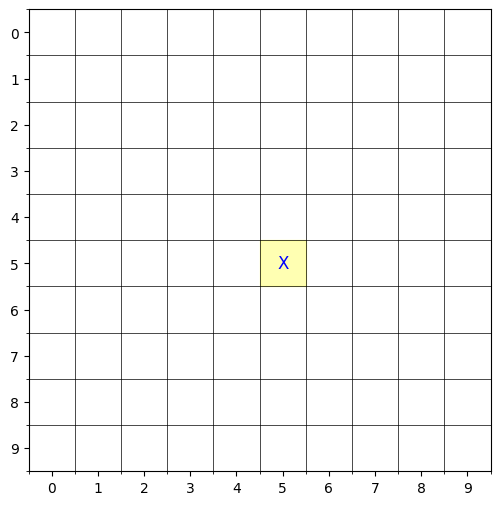

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (5, 6)


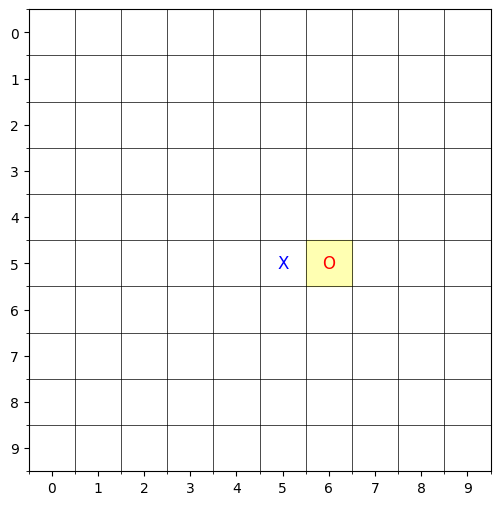

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (3, 8)


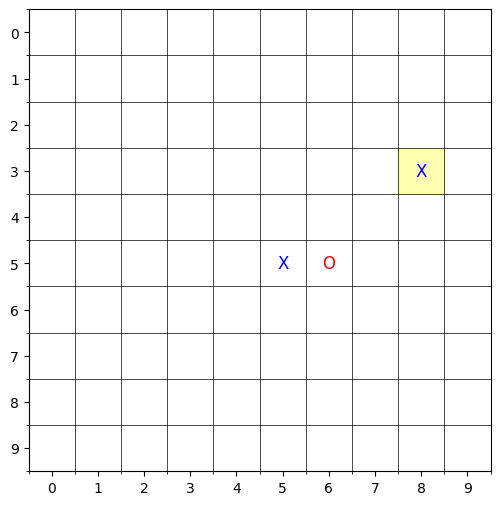

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (4, 8)


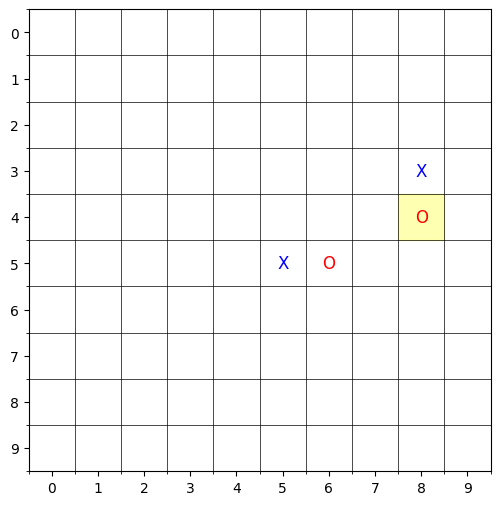

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (5, 7)


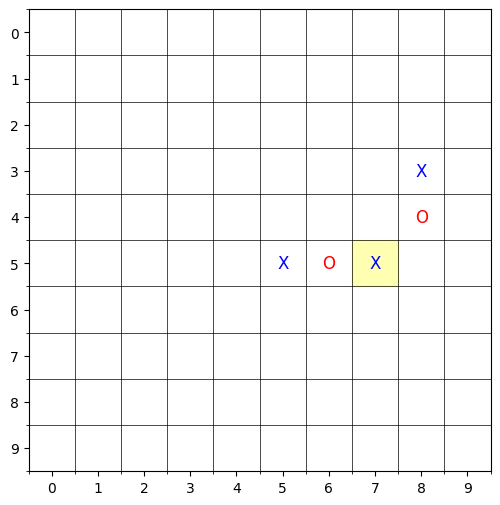

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (4, 6)


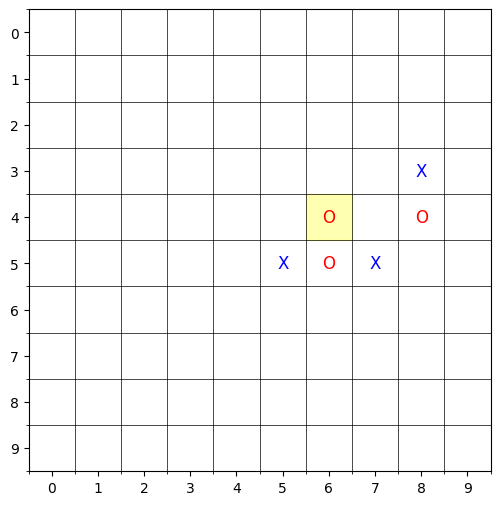

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (1, 9)


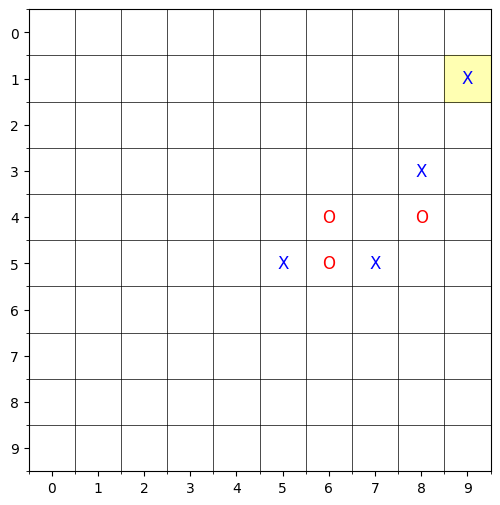

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (4, 7)


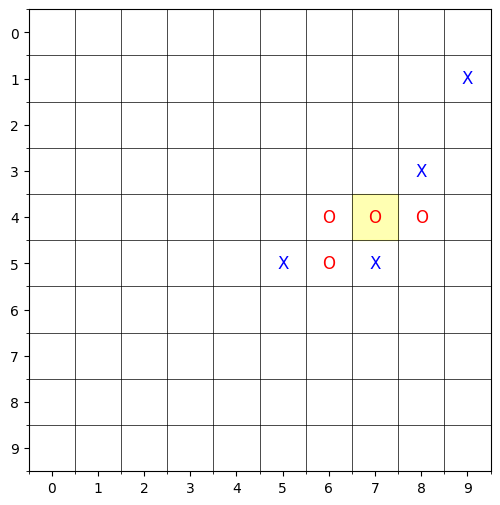

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (4, 5)


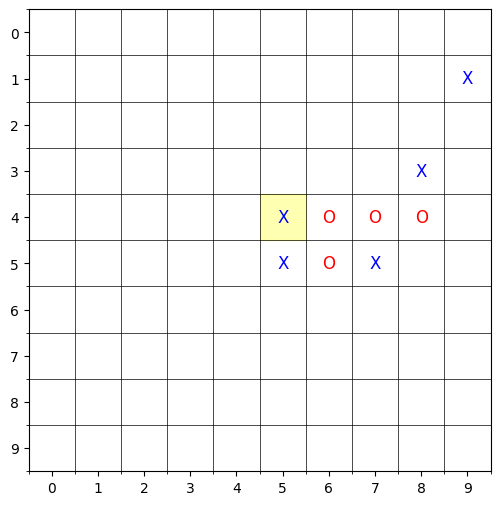

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (3, 6)


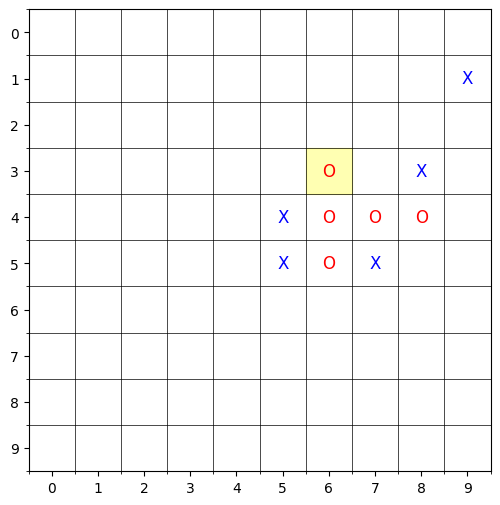

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (2, 6)


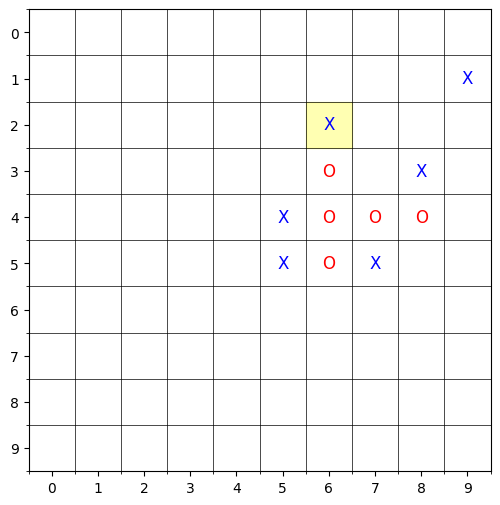

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (2, 5)


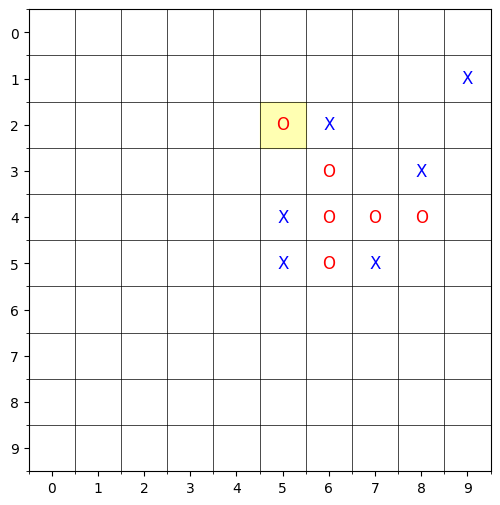

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (1, 4)


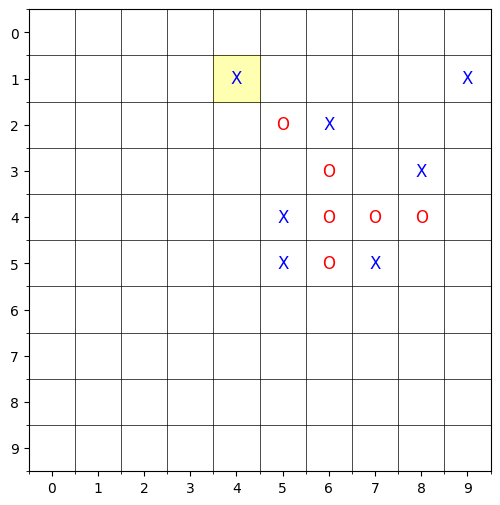

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (6, 6)


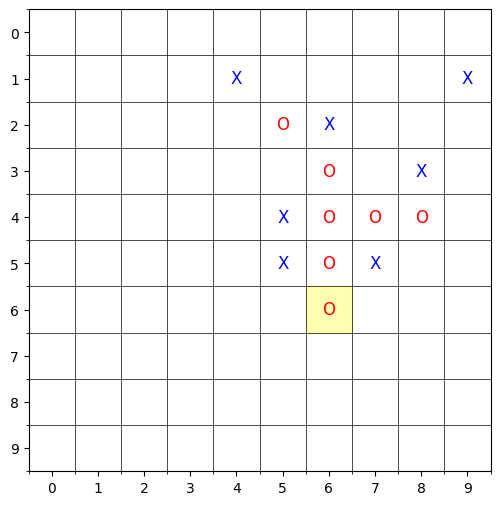

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (7, 6)


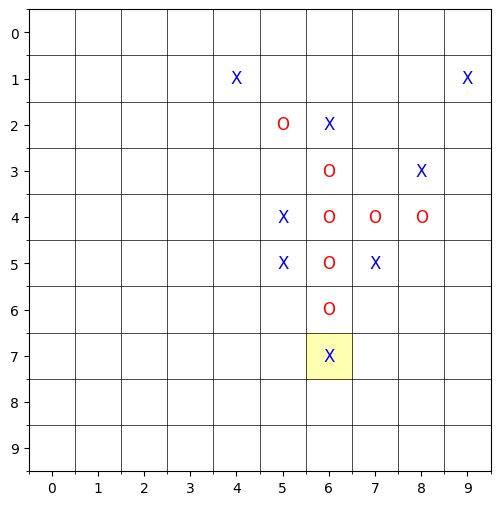

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (4, 4)


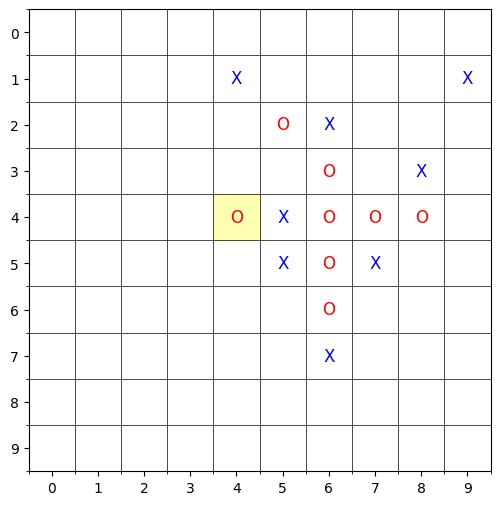

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (4, 9)


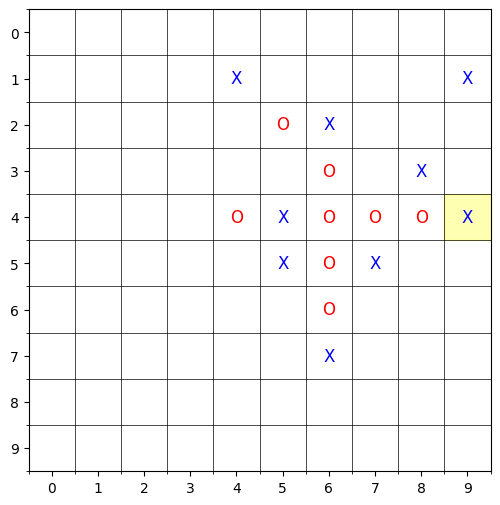

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (0, 2)


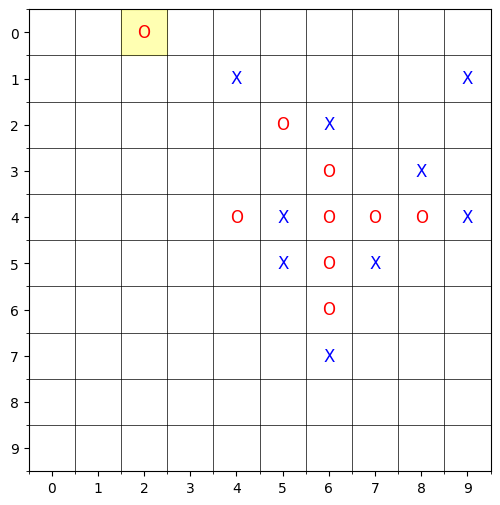

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (5, 8)


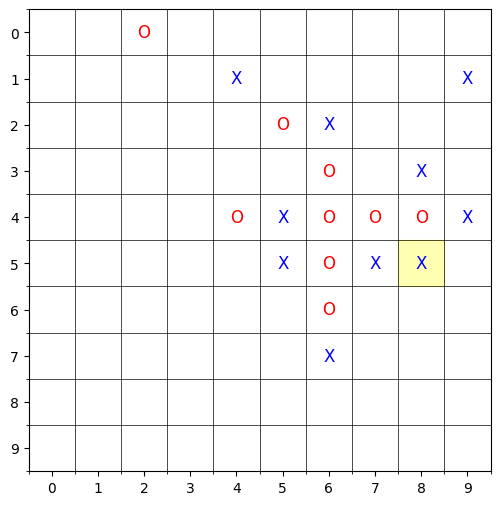

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (6, 7)


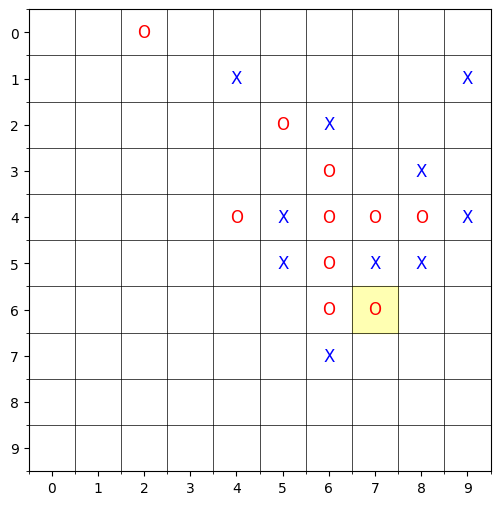

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (2, 7)


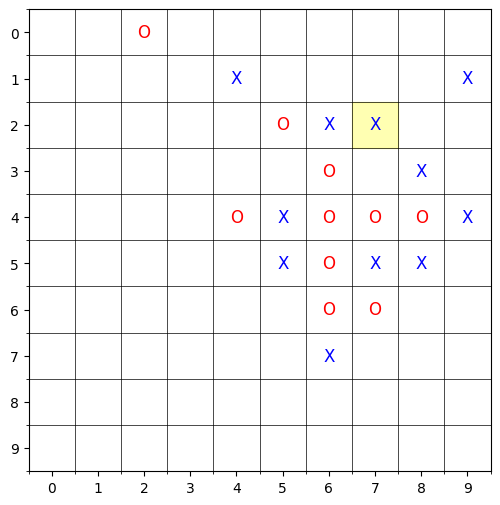

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (1, 6)


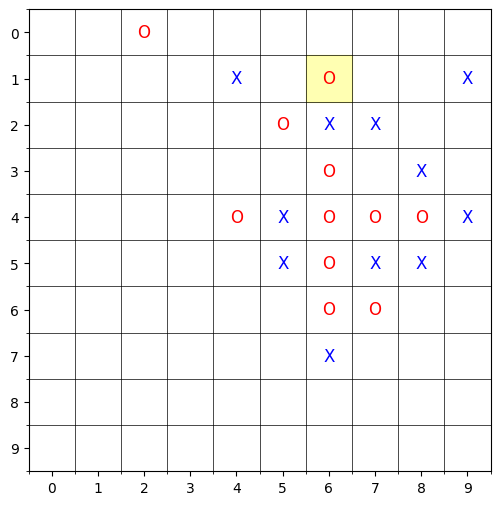

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (6, 5)


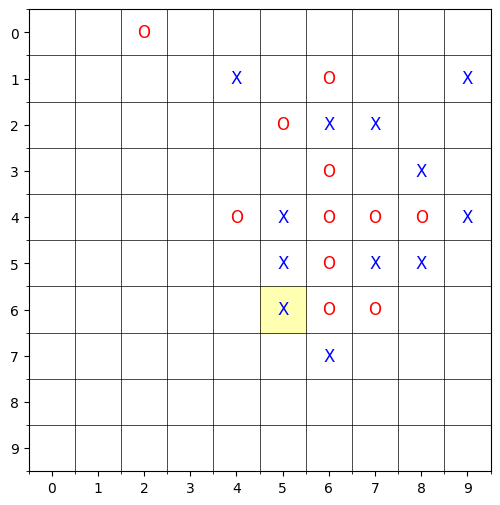

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (3, 5)


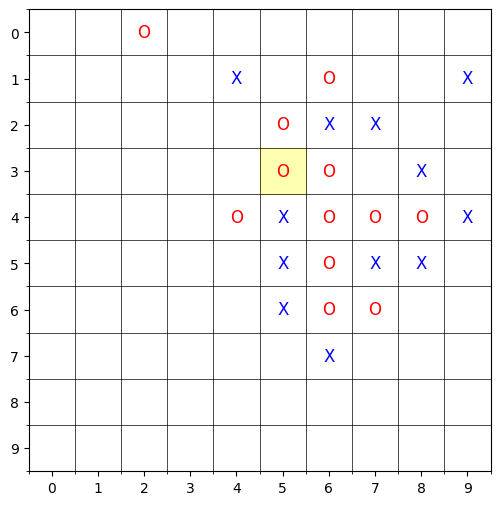

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (5, 4)


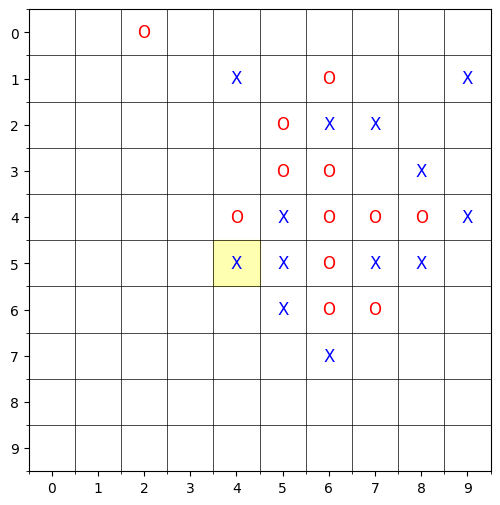

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (4, 3)


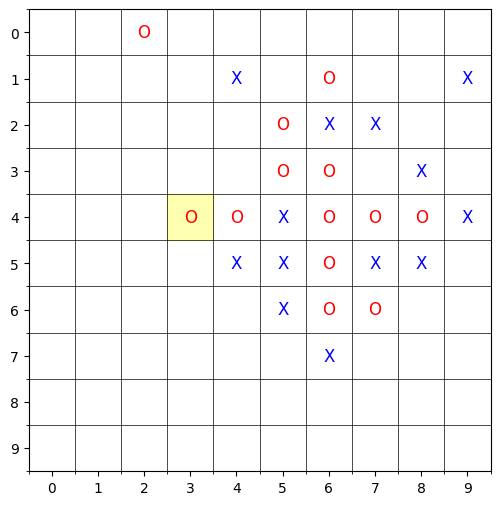

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (3, 4)


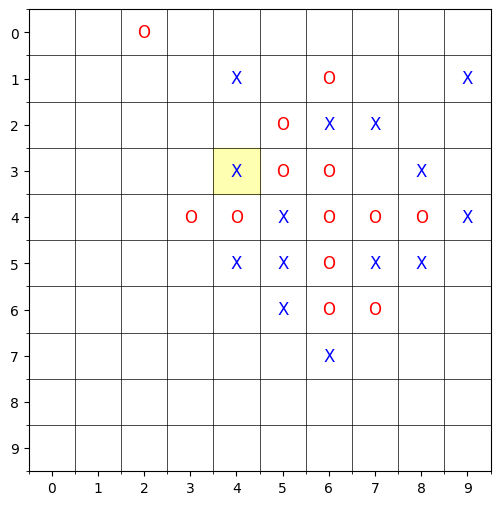

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (7, 5)


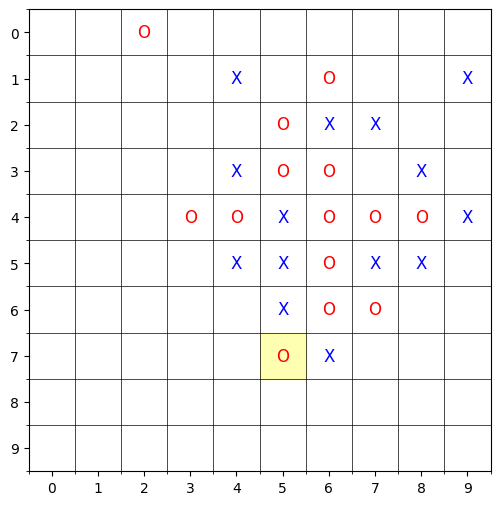

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (9, 8)


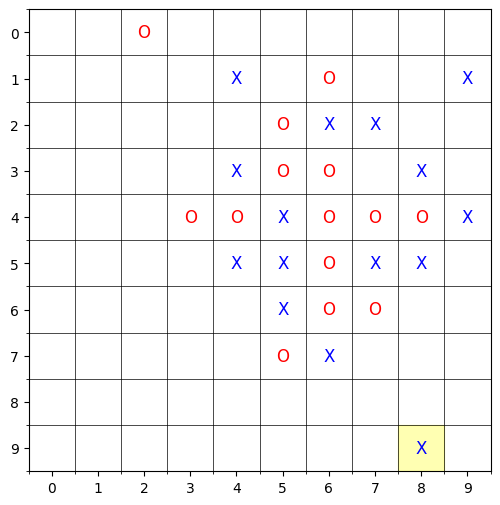

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (8, 7)


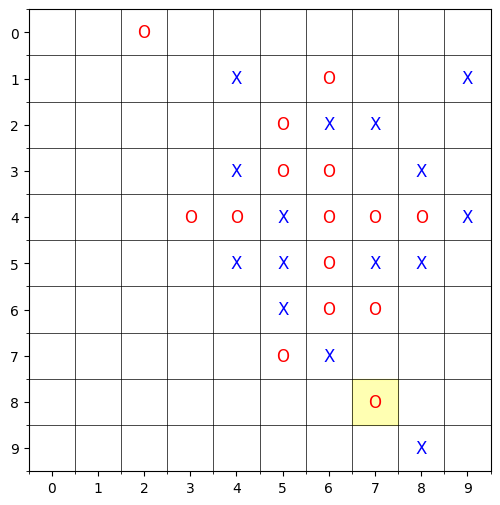

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (3, 7)


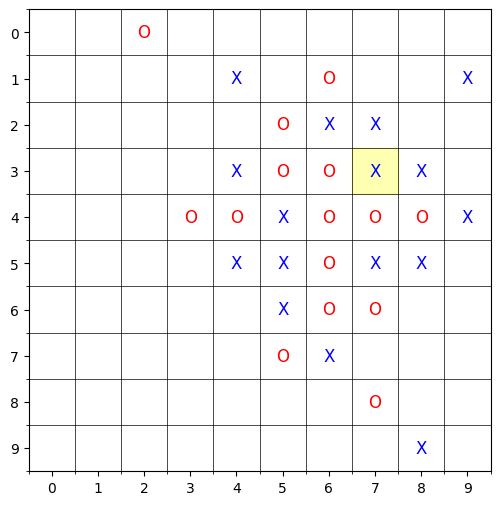

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (2, 3)


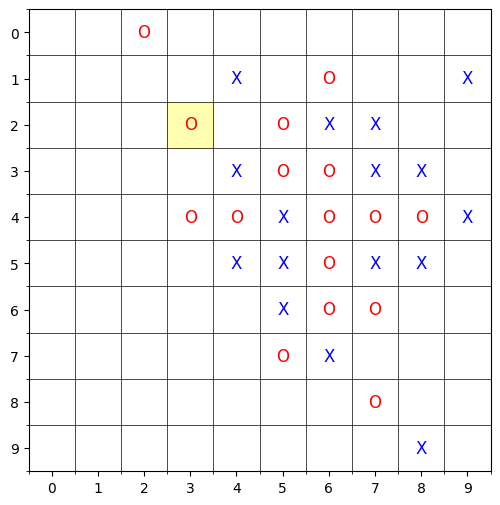

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (6, 4)


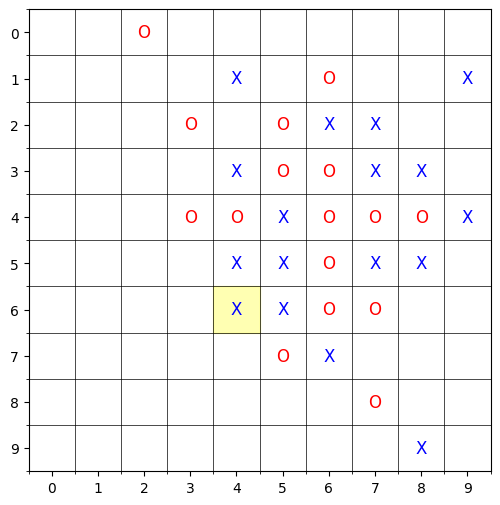

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (3, 3)


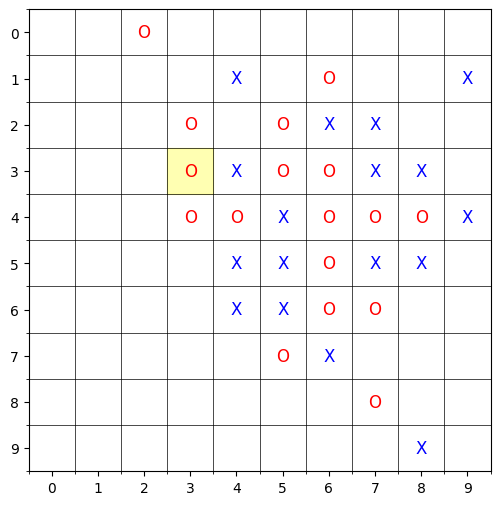

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (1, 3)


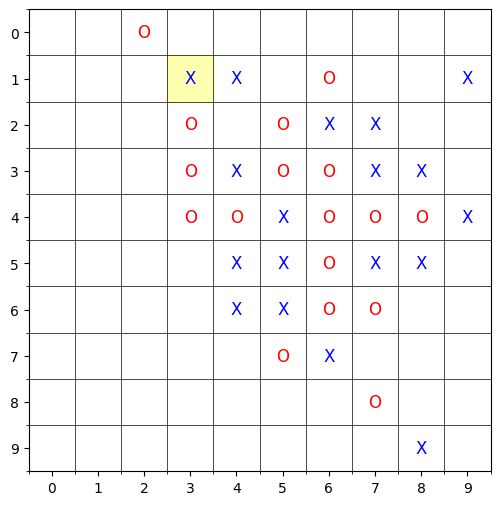

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (2, 8)


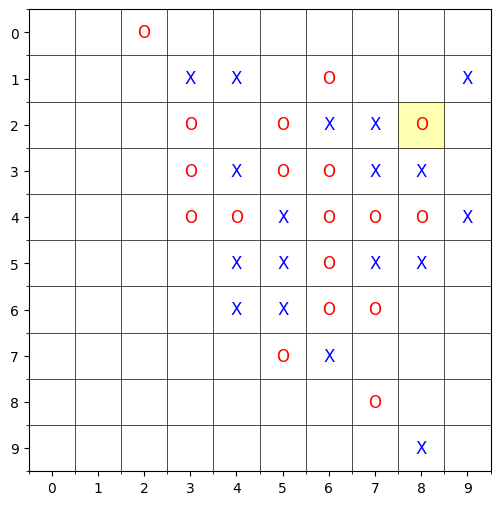

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (5, 3)


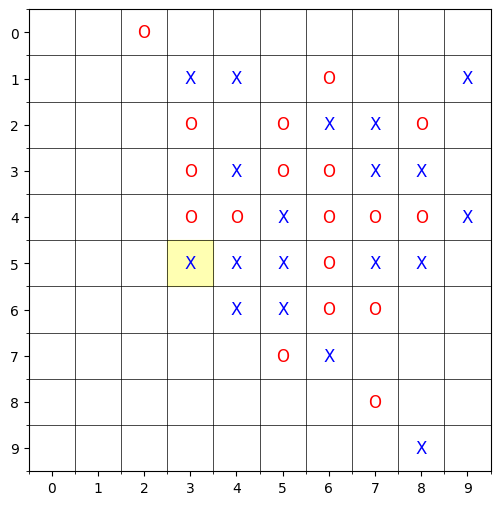

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (5, 2)


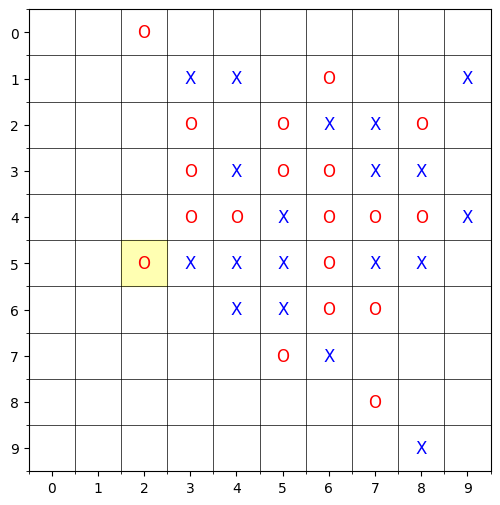

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (1, 2)


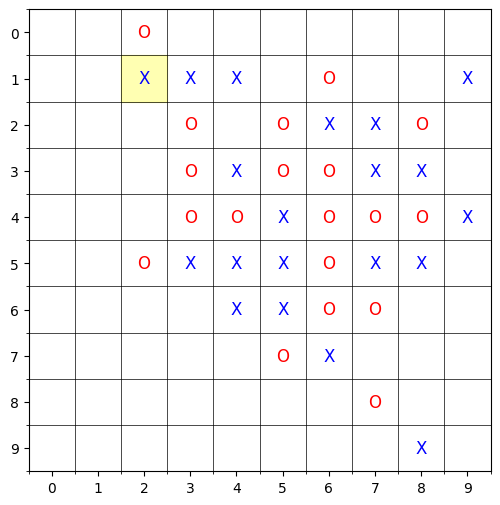

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (1, 1)


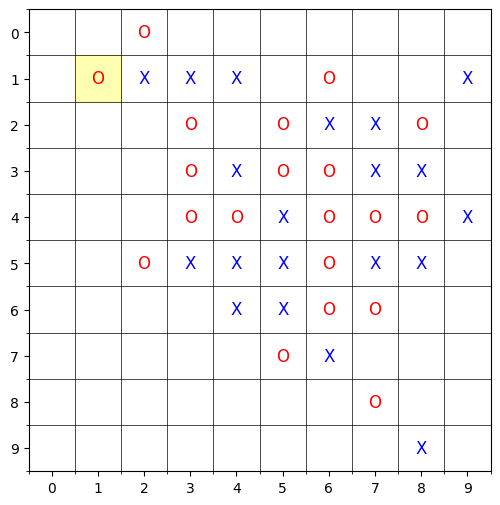

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (2, 2)


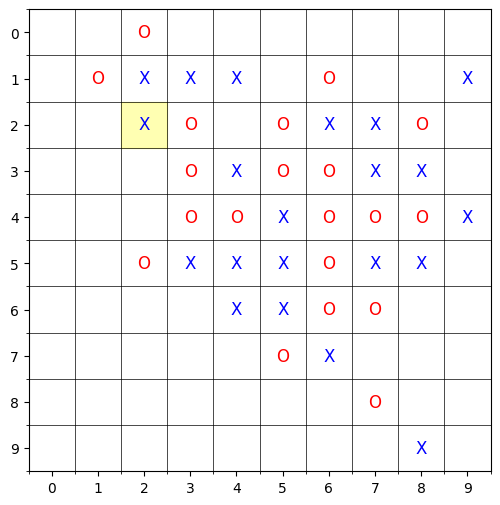

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (1, 5)


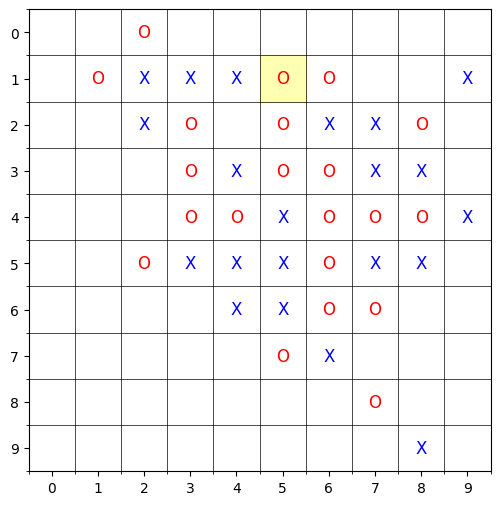

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (0, 5)


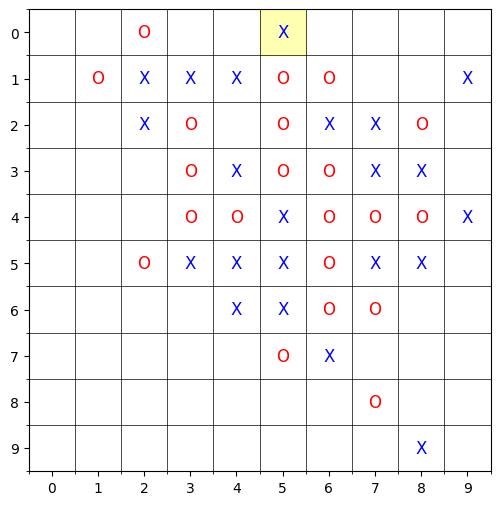

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (2, 0)


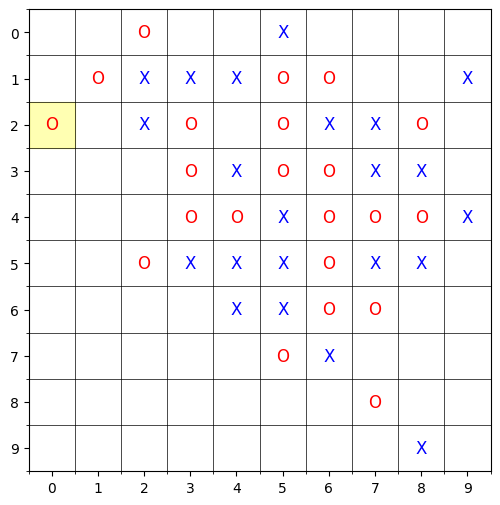

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (3, 1)


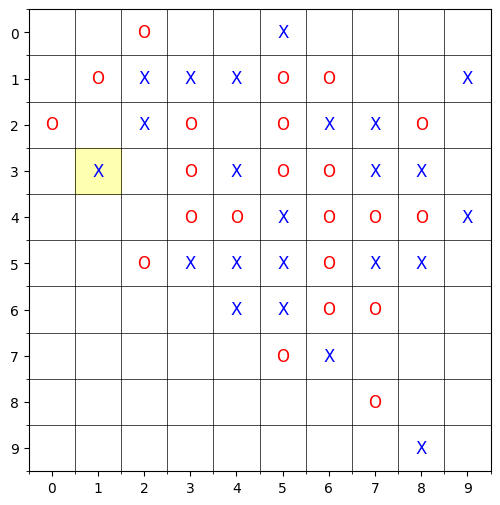

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (0, 4)


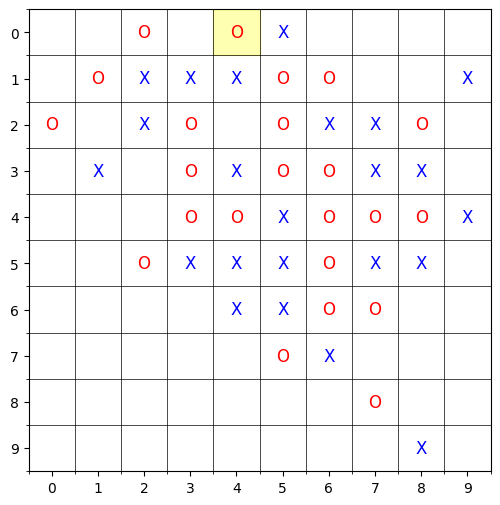

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (8, 0)


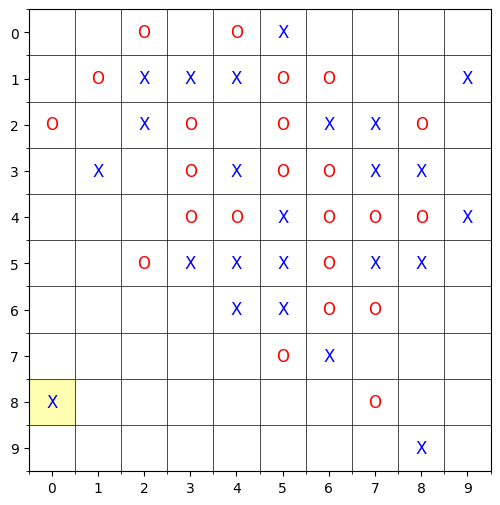

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (4, 0)


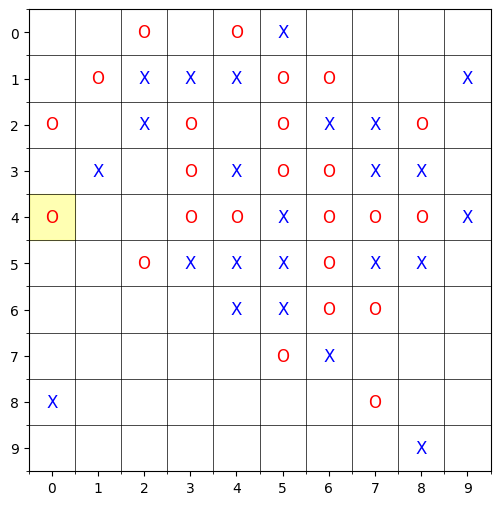

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (1, 0)


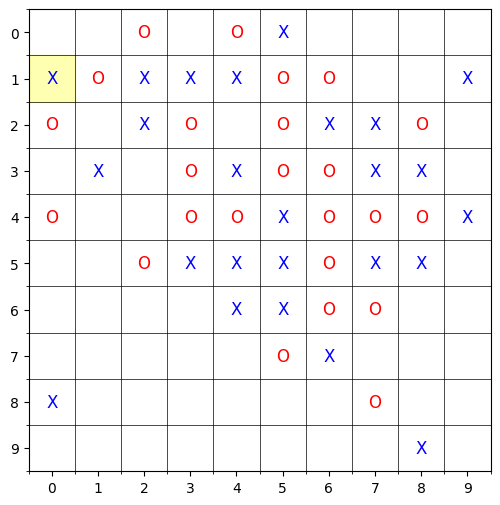

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (4, 2)


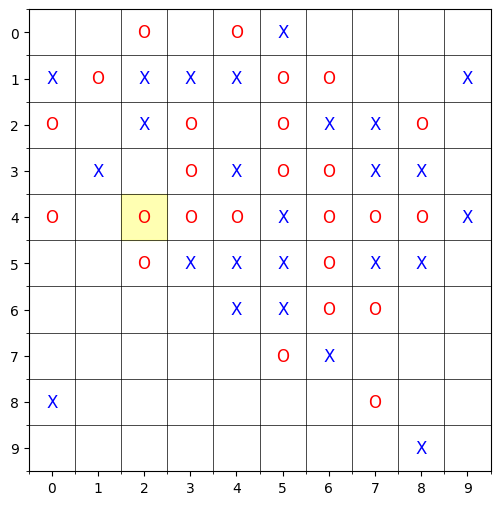

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (4, 1)


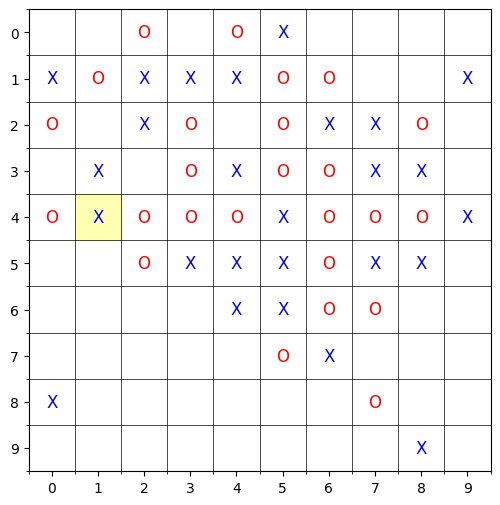

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (6, 2)


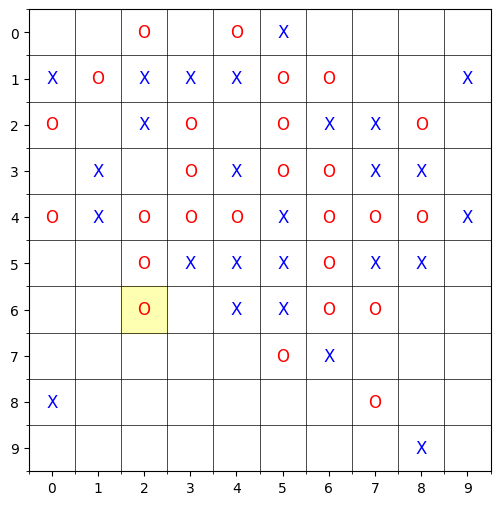

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (2, 4)


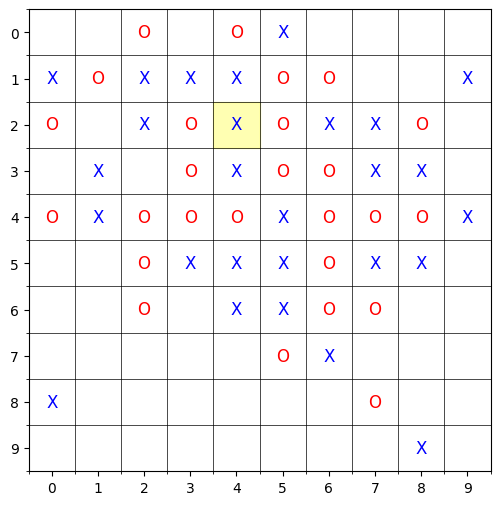

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (5, 1)


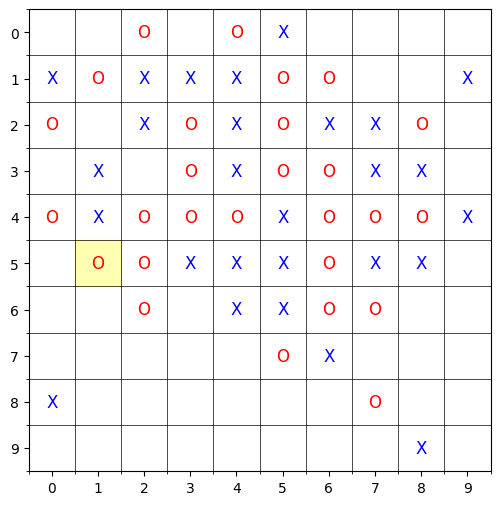

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (3, 2)


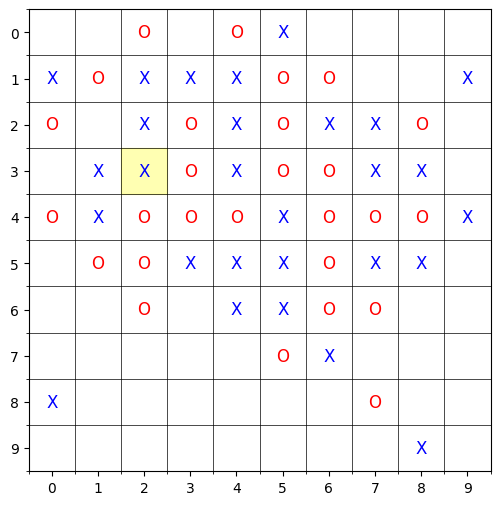

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (5, 0)


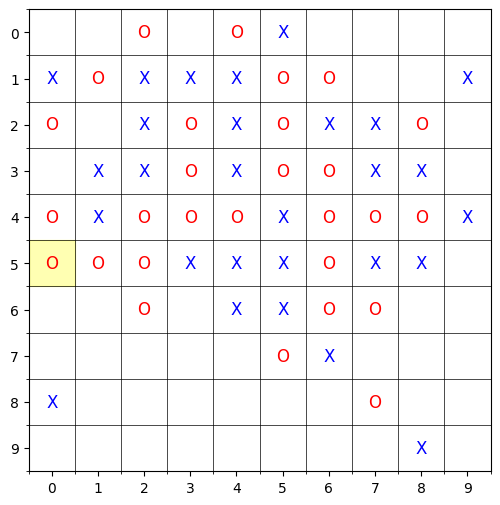

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (3, 0)


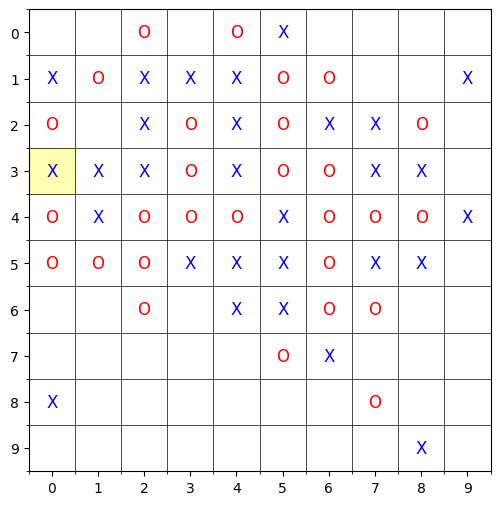

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (7, 7)


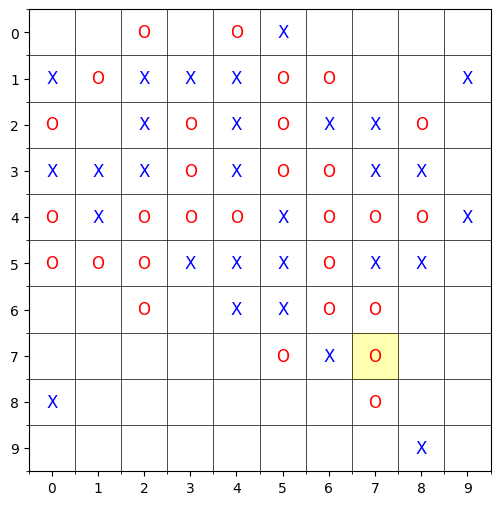

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (6, 0)


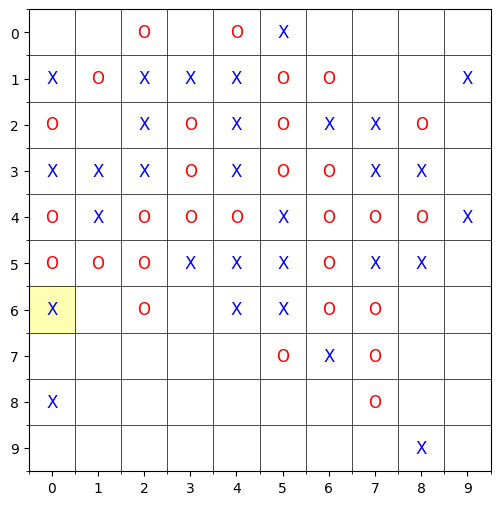

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (7, 3)


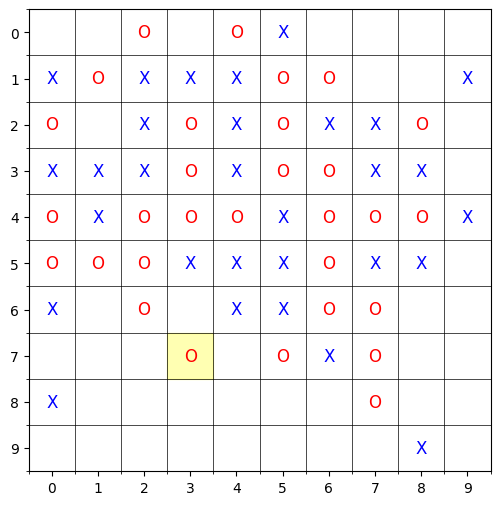

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (8, 4)


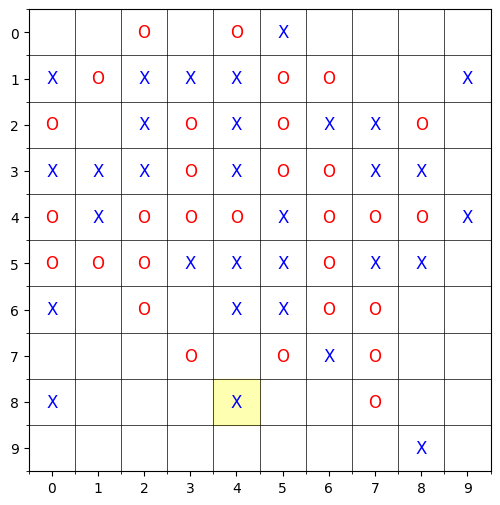

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (7, 4)


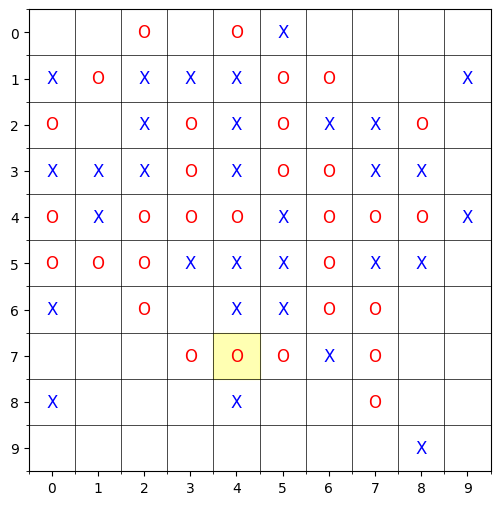

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (7, 2)


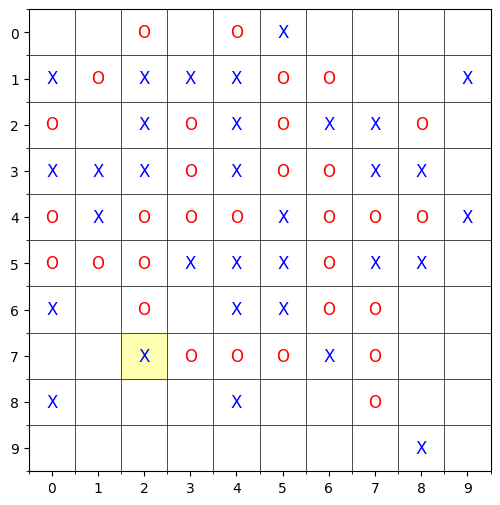

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (6, 3)


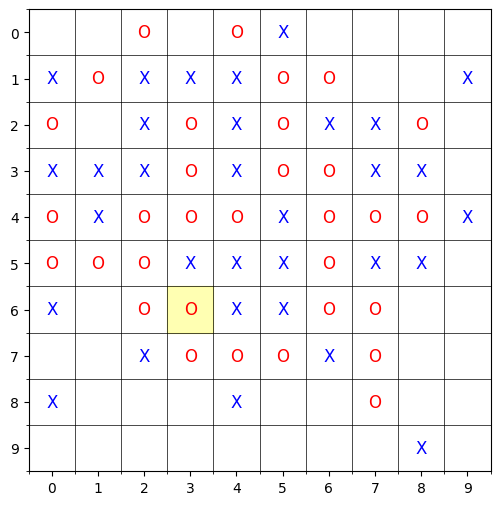

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (8, 5)


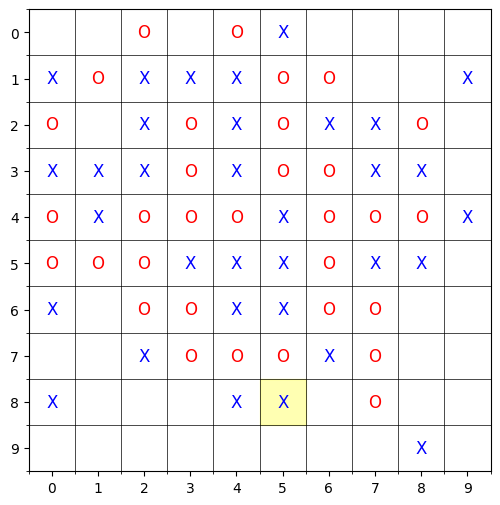

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (9, 3)


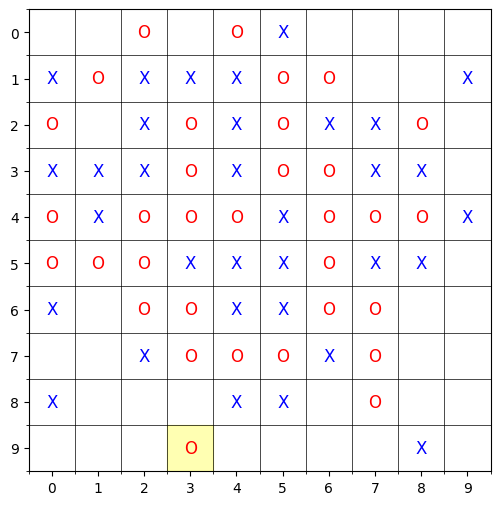

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (8, 3)


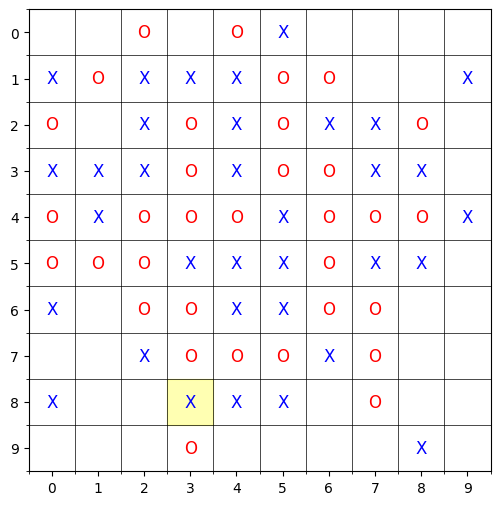

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (8, 2)


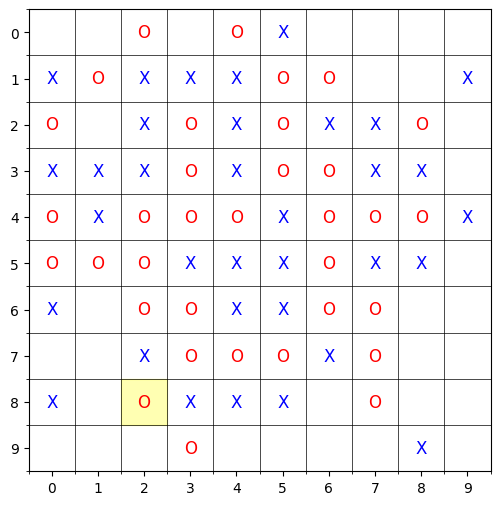

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (9, 7)


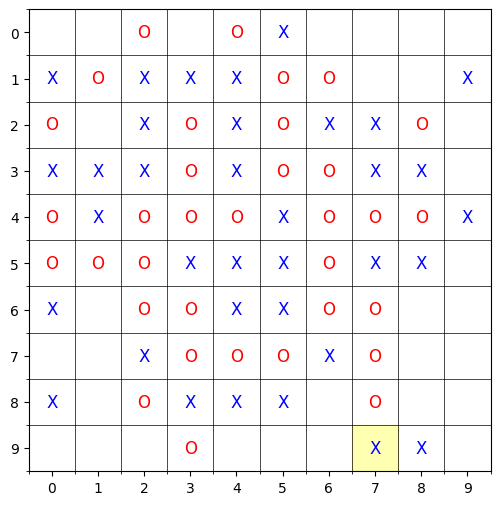

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (8, 6)


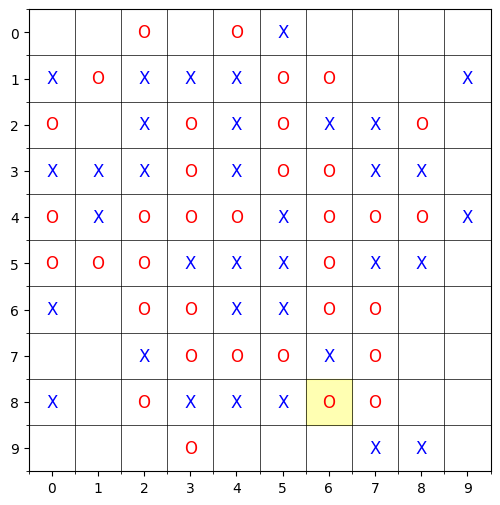

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (9, 6)


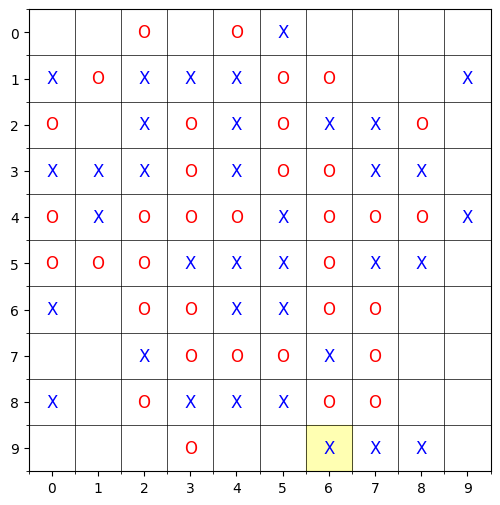

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (9, 5)


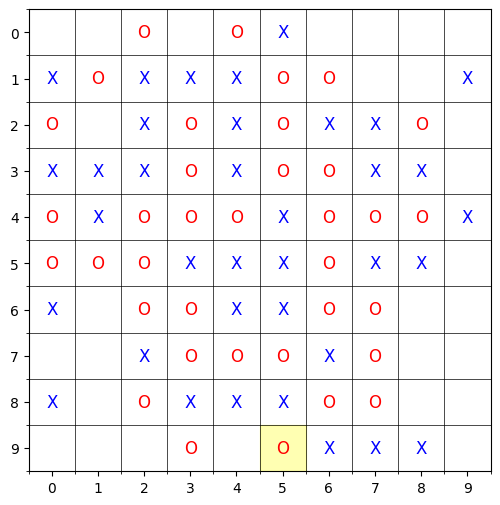

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (6, 8)


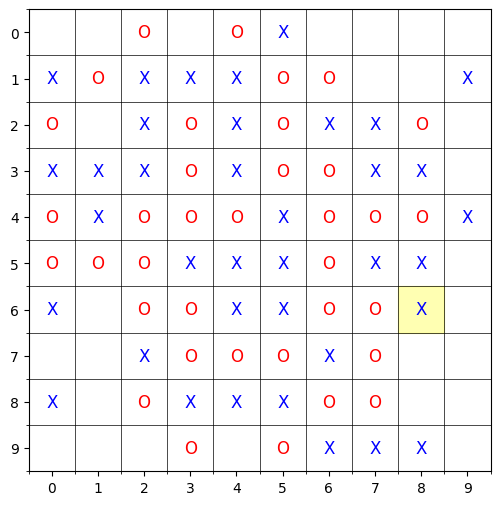

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (9, 9)


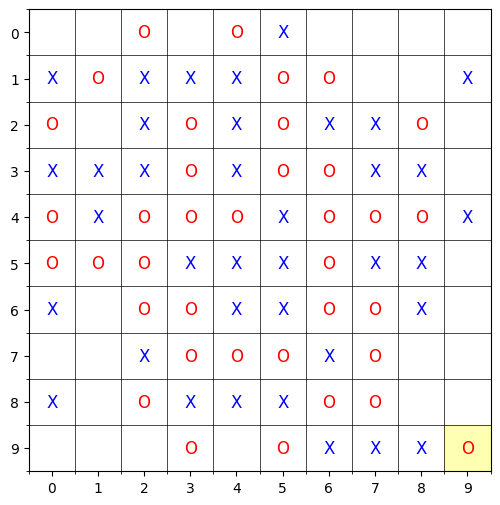

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (8, 8)


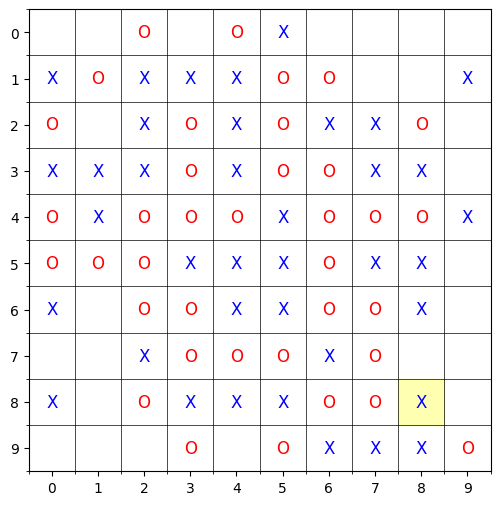

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (7, 8)


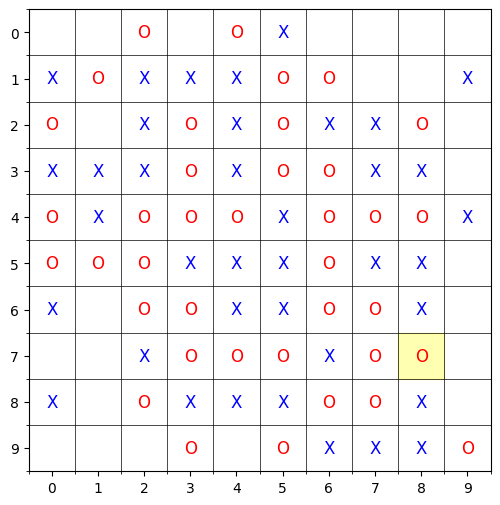

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (8, 9)


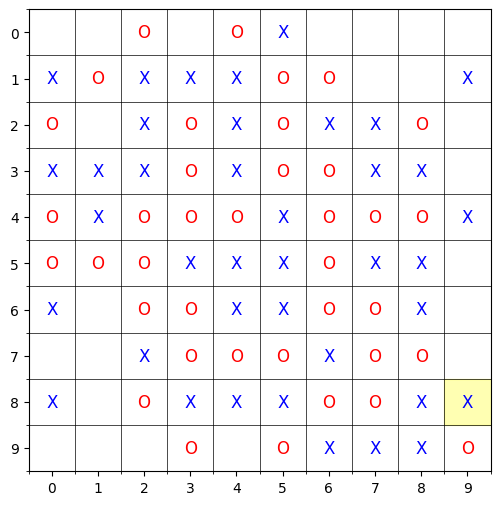

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (0, 1)


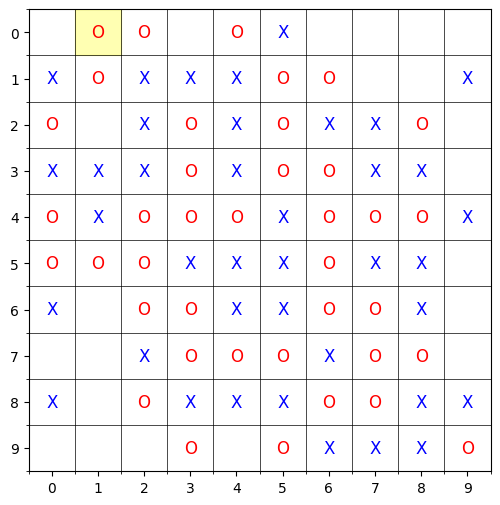

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (0, 3)


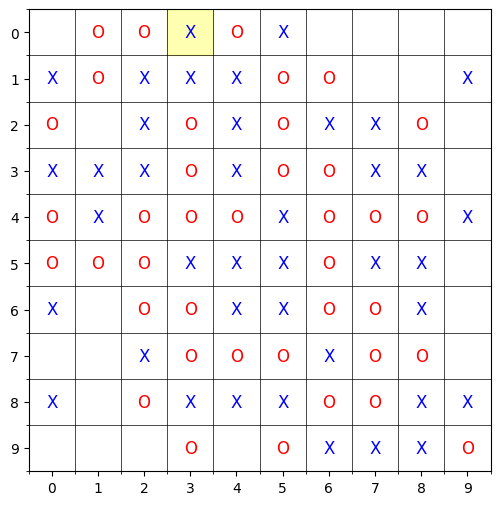

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (2, 1)


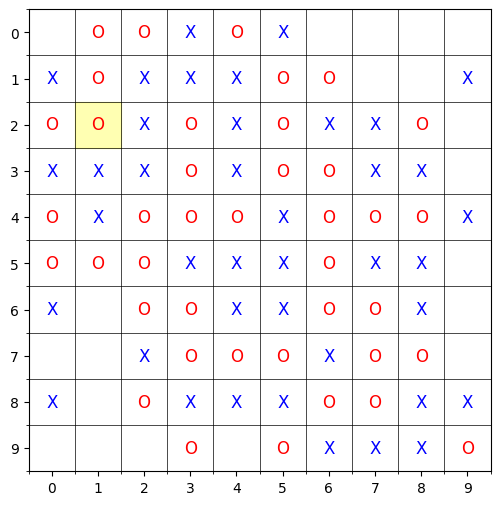

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (7, 9)


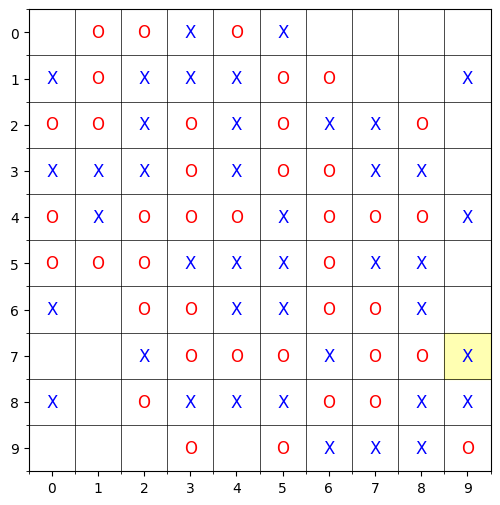

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (5, 9)


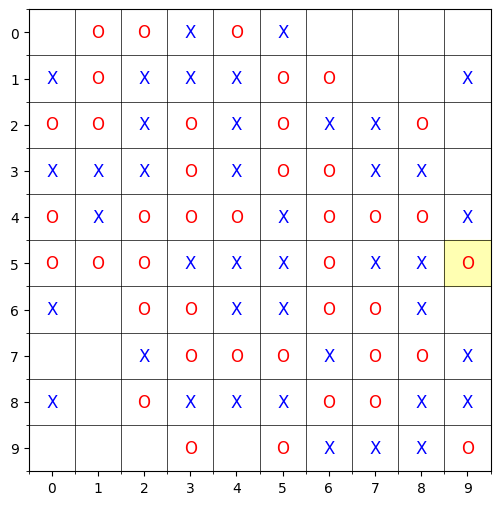

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (9, 4)


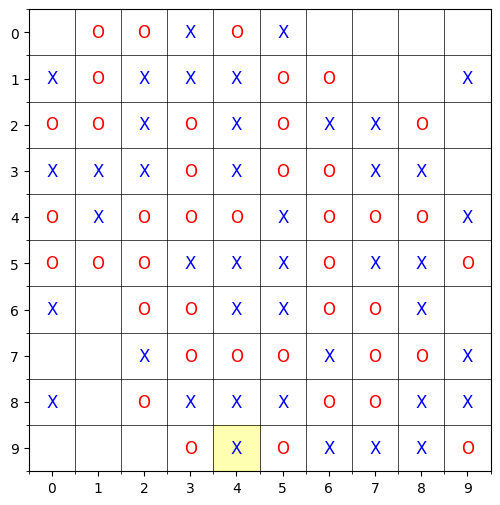

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (6, 1)


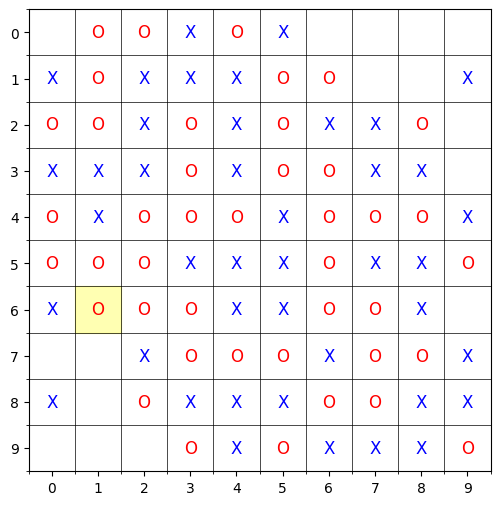

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (7, 0)


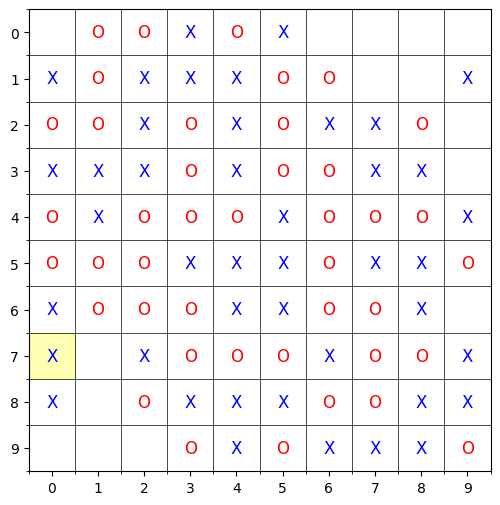

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (9, 0)


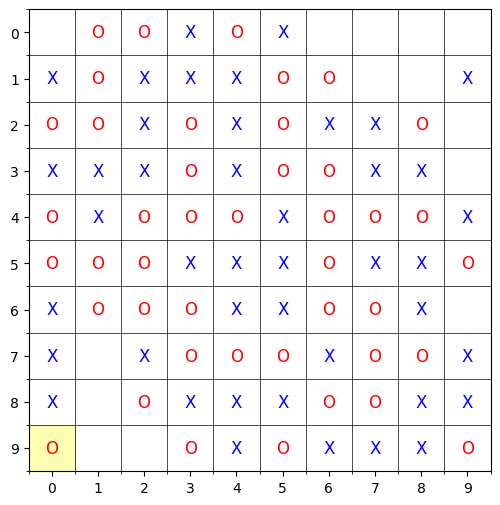

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (0, 6)


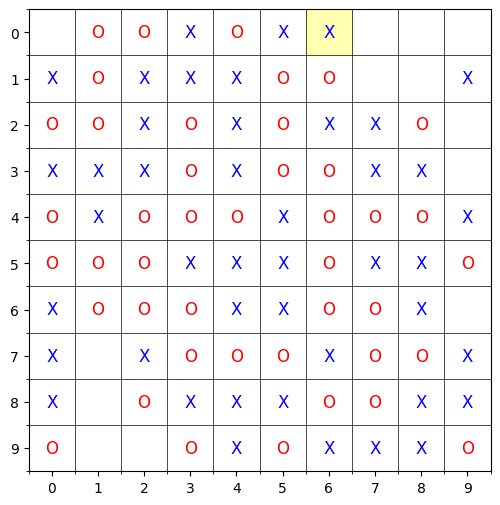

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (2, 9)


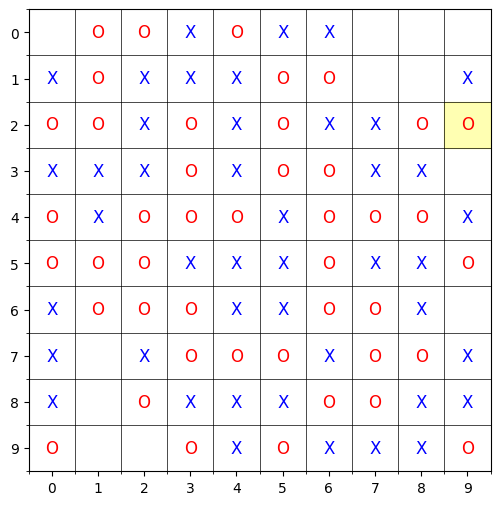

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (0, 8)


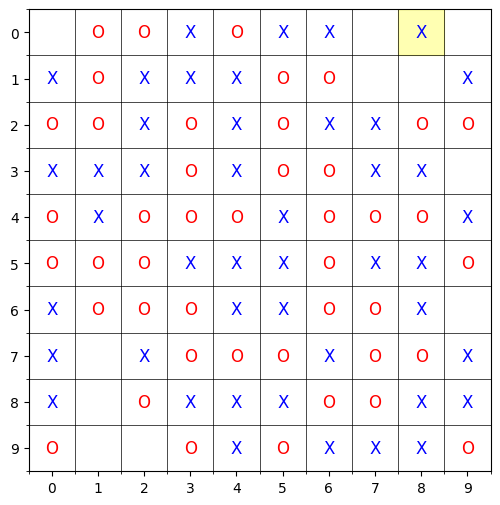

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (0, 7)


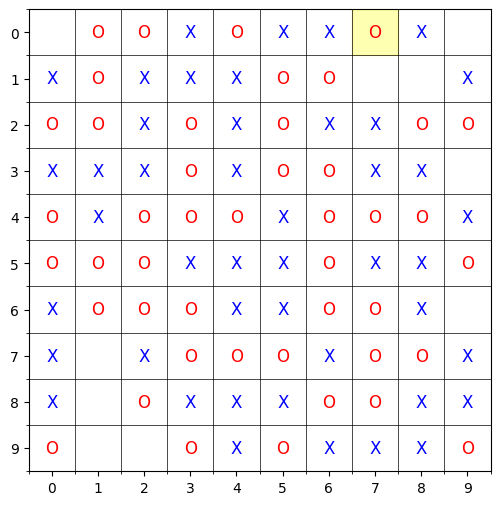

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (6, 9)


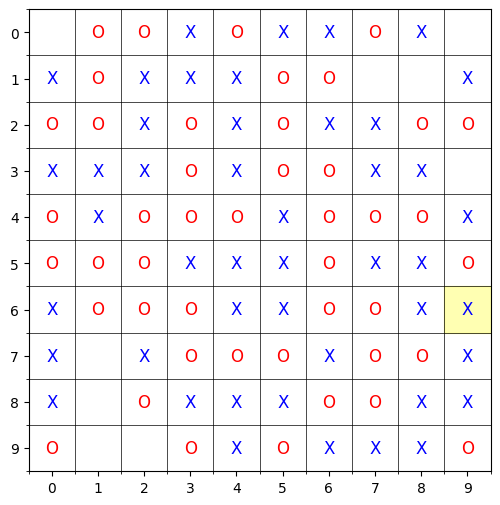

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (1, 8)


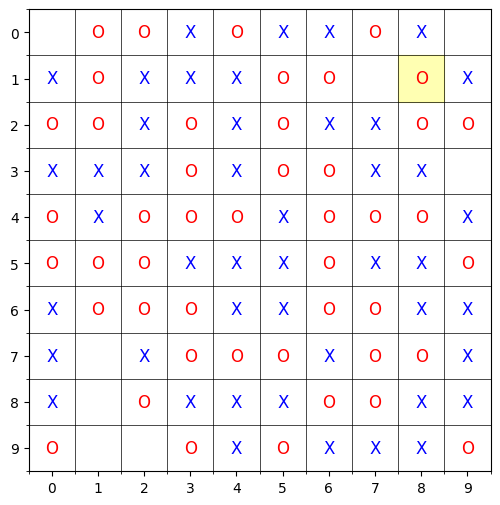

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (1, 7)


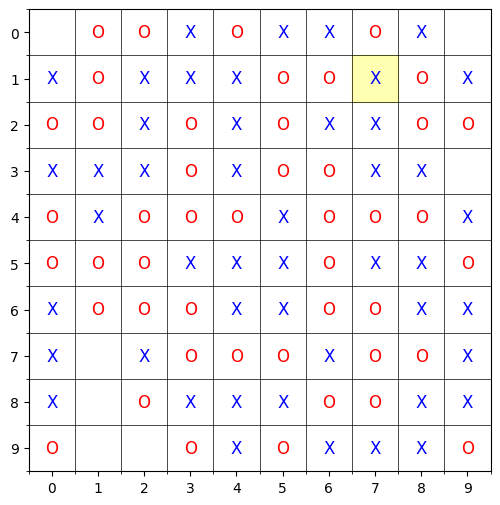

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (0, 0)


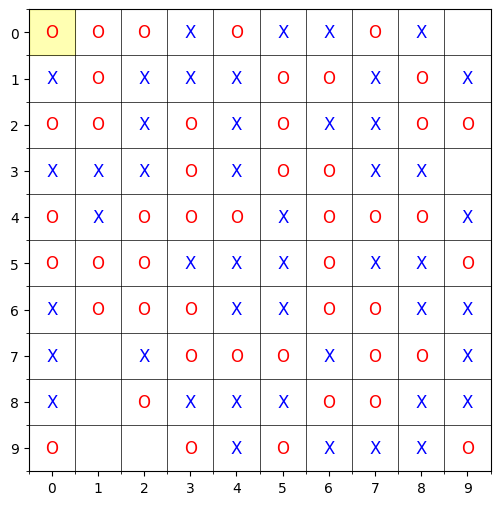

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (9, 1)


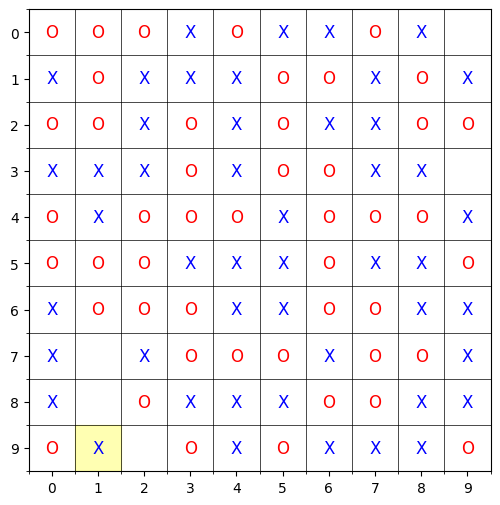

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (3, 9)


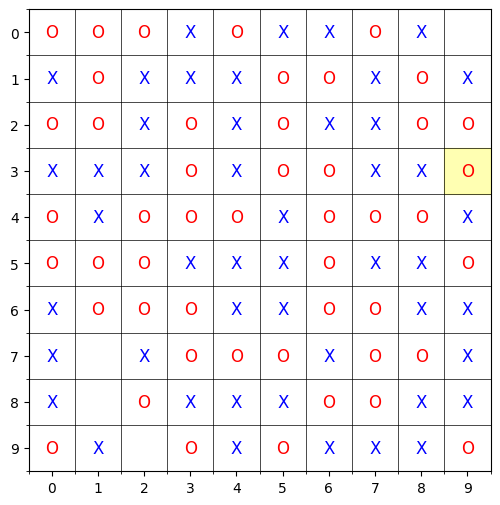

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (8, 1)


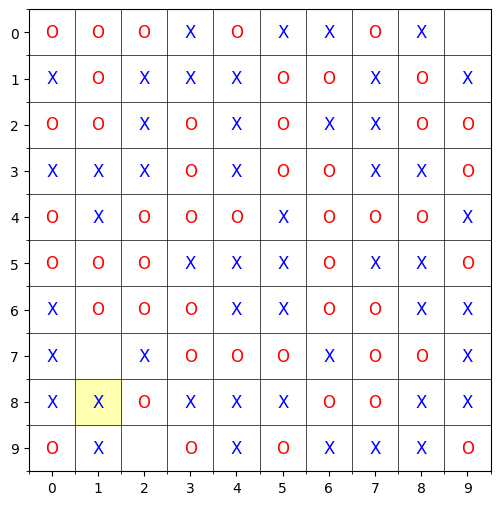

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (9, 2)


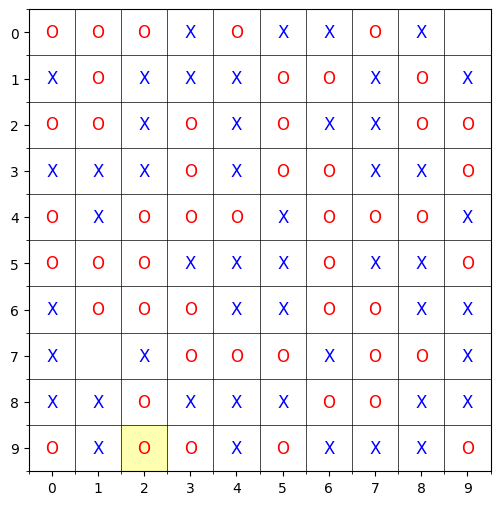

------------------------------
DDQN ch·ªçn n∆∞·ªõc ƒëi: (7, 1)


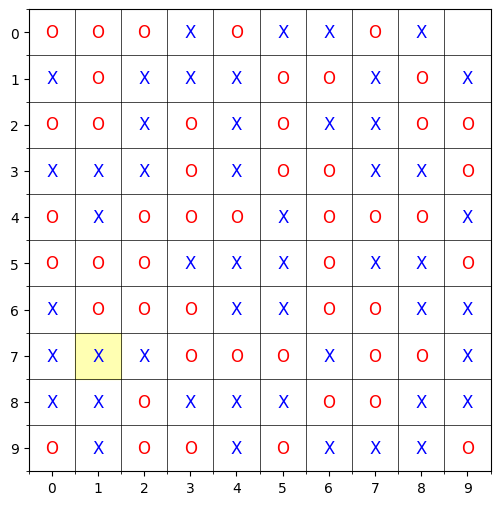

------------------------------
DQN ch·ªçn n∆∞·ªõc ƒëi: (0, 9)


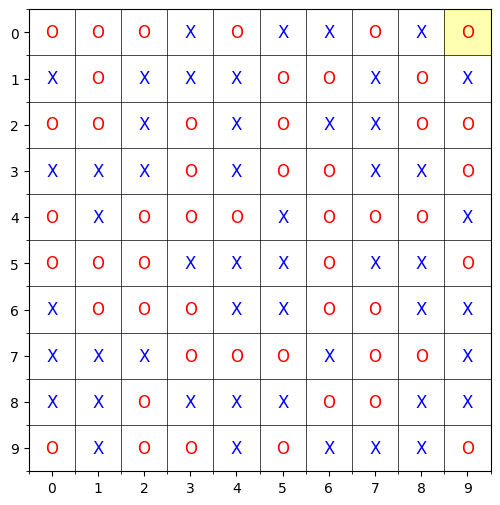

------------------------------
ü§ù H√≤a!


In [ ]:
play_match_verbose(env, agentdqn, agentddqn, delay=1.5)


In [ ]:
play_with_bot(lambda env: TrainedAgent(modeldqn, env))


Output()